In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

import sys
sys.path.append('..')
import utils.word_transition_network as wtn_module
from utils.rover import RoverVotingScheme
from utils.word_transition_network import *

from collections import Counter
import collections

from irover_application.extract_features import Processor

In [123]:
import utils.metrics as utils_metrics

In [2]:
import yt.wrapper as yt
yt.config.set_proxy("hahn")

In [5]:
assistant_table = yt.read_table(
    "//home/voice/edvls/tickets/VA-442_ideal_testsets/assistant_ideal_annotations_2019-02-16__2019-02-25"
)
assistant_table = list(assistant_table)
assistant_table[0].keys()

dict_keys(['yang_assignments_repeat_1', 'mds_key', 'linguists_sugested_text', 'toloka_text', '_other', 'check_in_yang_results', 'toloka_assignments_repeat_5_with_chorus_and_pitch', 'toloka_assignments_repeat_9_selected_workers_with_chorus_and_pitch', 'date', 'number_of_speakers', 'toloka_assignments_repeat_4_with_bend', 'text', 'raw_text_linguists', 'linguists_comment', 'toloka_assignments_repeat_3_with_pitch', 'toloka_number_of_speakers', 'toloka_assignments_repeat_6_with_chorus', 'toloka_assignments_repeat_1', 'toloka_assignments_repeat_7_with_chorus_and_pitch', 'toloka_assignments_repeat_8_selected_workers_with_chorus_and_pitch', 'speech', 'linguists_worker_id', 'toloka_speech', 'mark', 'toloka_assignments_repeat_11_selected_workers_with_pitch', 'toloka_assignments', 'toloka_assignments_repeat_10', 'toloka_assignments_repeat_2_with_pitch', 'audio', 'url'])

In [4]:
quasar_table = yt.read_table(
    "//home/voice/edvls/tickets/VA-442_ideal_testsets/quasar-general_with_spotter_ideal_annotations_2019-04-18__2019-04-24"
)
quasar_table = list(quasar_table)
quasar_table[0].keys()

dict_keys(['mds_key', 'linguists_sugested_text', 'toloka_text', 'toloka_assignments_repeat_2_with_chorus_and_pitch', 'spotter_tail_trim', 'toloka_assignments_repeat_4_selected_workers_with_pitch', '_other', 'check_in_yang_results', 'spotter_mds_key', 'date', 'number_of_speakers', 'text', 'downloadUrl', 'toloka_assignments_repeat_3_selected_workers_with_chorus_and_pitch', 'spotter_max_length', 'raw_text_linguists', 'linguists_comment', 'toloka_number_of_speakers', 'mdsFileName', 'toloka_assignments_repeat_1', 'speech', 'linguists_worker_id', 'toloka_speech', 'mark', 'url_in_first_toloka', 'asr_mds_key', 'toloka_assignments', 'audio', 'url', 'initialFileName'])

In [16]:
data_table = []
for row in assistant_table:
    data_table.append({'mds_key': row['mds_key'], 
                       'raw_assesments': row['toloka_assignments_repeat_11_selected_workers_with_pitch'],
                       'mark': row['mark'],
                       'text': row['text']})
for row in quasar_table:
    data_table.append({'mds_key': row['mds_key'], 
                       'raw_assesments': row['toloka_assignments_repeat_4_selected_workers_with_pitch'],
                       'mark': row['mark'],
                       'text': row['text']})

In [8]:
AggregationResult = collections.namedtuple('AggregationResult', 'text confidence cost')

In [31]:
Context = collections.namedtuple('Context', 'max_num_answers for_fitting platform')
context = Context(10, True, 'toloka')
context

Context(max_num_answers=10, for_fitting=True, platform='toloka')

In [10]:
def convert_to_array(features):
    X = list()
    Y = list()
    for task_id, item0 in features.items():
        for cost, item1 in item0.items():
            for position, item2 in item1.items():
                for word, item3 in item2.items():
                    x, y = item3
                    X.append(np.array(x))
                    Y.append(1 if y else -1)
    return np.array(X), np.array(Y)

In [130]:
def aggregate_prod(raw_data):
    """
       aggregation from prod
    """
    cost = 2
    while cost < 5:
        cost += 1
        answers = [(x["text"], x["speech"]) for x in raw_data[:cost]]
        answers = Counter(answers)
        if answers.most_common(1)[0][1] >= 3:
            break

    texts = Counter()
    speechs = Counter()
    for text, speech in [(x["text"], x["speech"]) for x in raw_data[:cost]]:
        if speech != "BAD" and text:
            text = text.lower().replace('ё', 'е')
        else:
            text = ""
        speechs.update([speech])
        texts.update([text])
    
    
    text, text_rate = max(texts.items(), key=lambda x: (x[1], x[0] != "", -x[0].count('?')))
#     if text != "" and text_rate >= 2:
    if text_rate >= 2:
        conf = text_rate * 1.0 / sum(texts.values())
    else:
        text = None
        conf = 0
    common = speechs.most_common(2)
    speech, speech_rate = common[0]
    if speech == "BAD" and len(common) >= 2 and common[1][1] == speech_rate:
        speech = common[1][0]

    # conf = text_rate / sum(texts.values())
    return AggregationResult(text, conf, cost)

In [81]:
def evaluate_metrics(data, field, algorithm, treshhold=0, cluster_refernces=None, print_=True):
    errors = 0
    total_length = 0
    aggregated = 0
    total_items = 0
    correct = 0
    cost = 0
    words_count = 0
    for row in data:
        if row["mark"] != "TEST":
            continue
        total_items += 1
        hyp = algorithm(sorted(row[field], key=lambda x: x["submit_ts"]))
        cost += hyp.cost
        if (hyp.text is None) or (hyp.confidence < treshhold):
            continue
        hyp = hyp.text
        aggregated += 1
        words_count += len(row["text"].split())
        _, e, l = calculate_wer(row["text"], hyp, cluster_refernces)
        errors += e
        if e == 0:
            correct += 1
        total_length += l

    accuracy = correct / aggregated
    wer = errors / total_length
    aggregated_part = aggregated / total_items
    cost = cost / total_items
    if print_:
        print("Aggregated: {:.4%}\nWER: {:.4%}\nAccuracy: {:.4%}\nMean overlap: {:.4}".format(
            aggregated_part, wer, accuracy, cost
        ))
    return aggregated_part, wer, accuracy, cost, words_count

In [13]:
import copy

In [17]:
valid_table = copy.deepcopy(data_table)

In [21]:
valid_rows = [row for row in valid_table if row["mark"] == "TEST"]

In [22]:
def preaggregate_with_clf(features, clf):
    matching = dict()
    X = list()
    for task_id, item0 in features.items():
        task_id = '/'.join(task_id.split('/')[-2:])
        for cost, item1 in item0.items():
            for position, item2 in item1.items():
                for word, item3 in item2.items():
                    x, y = item3
                    X.append(np.array(x))
                    matching[(task_id, cost, position, word)] = len(X) - 1
    probabilites = clf.predict_proba(X)[:, 1]
    results = dict()
    for task_id, item0 in features.items():
        task_id = '/'.join(task_id.split('/')[-2:])
        results[task_id] = dict()
        for cost, item1 in sorted(item0.items()):
            results[task_id][cost] = list()
            for position, item2 in sorted(item1.items()):
                words = list(item2.keys())
                probs = np.array([probabilites[matching[(task_id, cost, position, word)]] for word in words])
                pos = np.argmax(probs)
                score = probs[pos]
                word = words[pos]
                results[task_id][cost].append((word, score))
    return results

In [87]:
def evaluate_metrics_from_dict(data, aggregation_results, treshhold=0, max_cost=10, cluster_refernces=None, print_=True, add_threshold=0.0):
    errors = 0
    total_length = 0
    aggregated = 0
    total_items = 0
    correct = 0
    cost = 0
    words_count = 0
    
    for row in data:
        if row["mark"] != "TEST":
            continue
        total_items += 1
        hyp = aggregation_results[row["mds_key"]]
        cost += hyp.cost
        if (hyp.text is None) or (hyp.cost != max_cost and hyp.confidence < treshhold + add_threshold) or hyp.confidence < treshhold:
            continue
        hyp = hyp.text
        aggregated += 1
        words_count += len(row["text"].split())
        _, e, l = calculate_wer(row["text"], hyp, cluster_refernces)
        errors += e
        if e == 0:
            correct += 1
        total_length += l

    accuracy = correct / aggregated
    wer = errors / total_length
    aggregated_part = aggregated / total_items
    cost = cost / total_items
    if print_:
        print("Aggregated: {:.4%}\nWER: {:.4%}\nAccuracy: {:.4%}\nMean overlap: {:.4}\nWords counted: {}".format(
            aggregated_part, wer, accuracy, cost, words_count
        ))
    return aggregated_part, wer, accuracy, cost, words_count

In [124]:
def aggregate_rover_with_clf_(rows, features, field_name, clf, treshhold=0.51, min_cost=3, max_cost=10, 
                              cluster_references=None, preaggregated=None):
    """
       aggregation from prod
    """
    clf_results = preaggregated
    if not clf_results:
        clf_results = preaggregate_with_clf(features, clf)
    results = dict()
    for task_id, item0 in clf_results.items():
        for cost, item1 in sorted(item0.items()):
            if cost < min_cost or cost > max_cost: 
                continue
            text = " ".join(value for value, score in item1 if value != "")
            score = sum(score for value, score in item1) / len(item1)
            if score >= treshhold or cost == max_cost: #MAX_NUM_ANSWERS:
#                 if text == "":
#                     conf = 0
#                     text = None
#                 elif score < treshhold:
                if score < treshhold:
                    conf = 0
                    text = None
                else:
                    conf = score
                results[task_id] = AggregationResult(text, conf, cost)
                break
    return results

In [125]:
def evaluate_metrics_clf_(data, 
                          features, 
                          field_name, 
                          clf, 
                          treshhold=0.51, 
                          min_cost=3, 
                          max_cost=10, 
                          cluster_refernces=None, 
                          print_=True,
                          agg_method=aggregate_rover_with_clf_):
    aggregation_results = agg_method(data, 
                                     features, 
                                     field_name, 
                                     clf, 
                                     treshhold=treshhold, 
                                     min_cost=min_cost, 
                                     max_cost=max_cost, 
                                     cluster_references=cluster_refernces)
    return utils_metrics.evaluate_metrics_from_dict(data, 
                                              aggregation_results, 
                                              treshhold,
                                              cluster_refernces, 
                                              print_)

In [26]:
prod_agg_metrics = evaluate_metrics(valid_rows, 
                                    'raw_assesments', 
                                    aggregate_prod) 

Aggregated: 77.4695%
WER: 6.9102%
Accuracy: 83.3966%
Mean overlap: 3.776


In [27]:
import matplotlib.pyplot as plt

In [28]:
train_rows_q = [row for row in data_table if row["mark"] == "TRAIN"]
test_rows_q = [row for row in data_table if row["mark"] == "TEST"]
for row in test_rows_q:
    if 'text' in row:
        del row['text']

In [29]:
train_proc_q = Processor(train_rows_q, context)
test_proc_q = Processor(test_rows_q, context)

for row in train_rows_q:
    value = {'raw_assesments': row['raw_assesments'],
            'inputValues': {'url': row['mds_key']},
            'text': row['text']}
    train_proc_q.rows.append(value)

for row in test_rows_q:
    value = {'raw_assesments': row['raw_assesments'],
            'inputValues': {'url': row['mds_key']},}
    test_proc_q.rows.append(value)

In [32]:
train_features_q = train_proc_q.extract_features()

In [ ]:
test_features_q = test_proc_q.extract_features()

In [ ]:
X_train_q, Y_train_q = convert_to_array(train_features_q)

In [ ]:
clf_q = CatBoostClassifier(iterations=19000, depth=7, thread_count=30, random_seed=42)
clf_q.fit(X_train_q, Y_train_q)
with open("log_assistant.txt", "a") as log:
    log.write("mixed datasets 10 overlap model is fitted\n")

In [ ]:
scores_clf_test_q = []

for treshhold in np.linspace(0.8, 0.98, 19):
    print(treshhold)
    metrics = evaluate_metrics_clf_(valid_rows, 
                                    test_features_q, 
                                    'raw_assesments', 
                                    clf_q, 
                                    treshhold,
                                    min_cost=3,
                                    max_cost=7)
    scores_clf_test_q.append((treshhold, *metrics))
scores_clf_test_q = np.array(scores_clf_test_q)

In [40]:
import pickle

In [42]:
with open('overlaps_assistant_10_overlap.pickle', 'rb') as f:
    scores_clf_loaded = pickle.load(f)
scores_clf_loaded

array([[0.8       , 0.75846242, 0.12047478, 0.68683812, 3.04475043],
       [0.81      , 0.75817556, 0.11980712, 0.68709799, 3.05565118],
       [0.82      , 0.75760184, 0.11836341, 0.68989019, 3.07028112],
       [0.83      , 0.75760184, 0.11838492, 0.69140477, 3.0831899 ],
       [0.84      , 0.75760184, 0.11720606, 0.69102613, 3.1124498 ],
       [0.85      , 0.75616753, 0.11557901, 0.69157815, 3.1394148 ],
       [0.86      , 0.75588067, 0.11462744, 0.69411765, 3.17441193],
       [0.87      , 0.75301205, 0.11341127, 0.69866667, 3.21170396],
       [0.88      , 0.7518646 , 0.10994257, 0.70240366, 3.25645439],
       [0.89      , 0.74641423, 0.10542101, 0.7121445 , 3.32071142],
       [0.9       , 0.7383821 , 0.09918169, 0.72261072, 3.38668962],
       [0.91      , 0.72948939, 0.09368776, 0.73220606, 3.45926563],
       [0.92      , 0.71629375, 0.08635054, 0.74809772, 3.55220884],
       [0.93      , 0.69764773, 0.07765983, 0.76315789, 3.67641997],
       [0.94      , 0.67756741, 0.

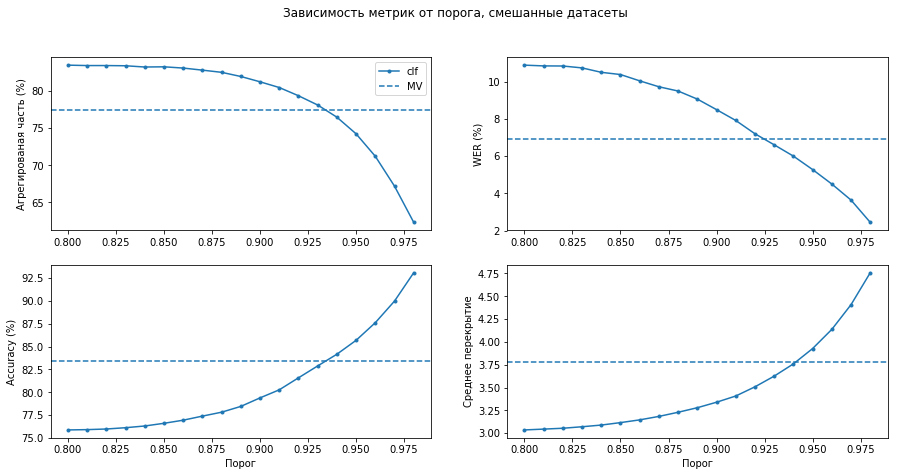

In [43]:
plt.figure(figsize=(15,7))
plt.suptitle('Зависимость метрик от порога, смешанные датасеты')
plt.subplot(221)
plt.plot(scores_clf_test_q[:, 0], 
         scores_clf_test_q[:, 1] * 100, 
         ".-", 
         label="clf")
plt.axhline(y=prod_agg_metrics[0] * 100, color=u'#1f77b4', linestyle='--', label="MV")
plt.legend()
plt.ylabel('Агрегированая часть (%)')

plt.subplot(222)
plt.plot(scores_clf_test_q[:, 0], 
         scores_clf_test_q[:, 2] * 100, 
         ".-")
plt.axhline(y=prod_agg_metrics[1] * 100, color=u'#1f77b4', linestyle='--')
plt.ylabel('WER (%)')


plt.subplot(223)
plt.plot(scores_clf_test_q[:, 0], 
         scores_clf_test_q[:, 3] * 100, 
         ".-")
plt.axhline(y=prod_agg_metrics[2] * 100, color=u'#1f77b4', linestyle='--')
plt.ylabel('Accuracy (%)')

plt.xlabel('Порог')

plt.subplot(224)
plt.plot(scores_clf_test_q[:, 0], 
         scores_clf_test_q[:, 4], 
         ".-")
plt.axhline(y=prod_agg_metrics[3], color=u'#1f77b4', linestyle='--')
plt.ylabel('Среднее перекрытие')

plt.xlabel('Порог')

plt.savefig("metrics_mixed_datasets.png")
plt.show()

In [44]:
valid_assistant_table = yt.read_table(
    "//home/voice/edvls/tickets/VA-442_ideal_testsets/assistant_ideal_annotations_2019-02-16__2019-02-25"
)
valid_assistant_table = list(valid_assistant_table)
valid_assistant_table[0].keys()

dict_keys(['yang_assignments_repeat_1', 'mds_key', 'linguists_sugested_text', 'toloka_text', '_other', 'check_in_yang_results', 'toloka_assignments_repeat_5_with_chorus_and_pitch', 'toloka_assignments_repeat_9_selected_workers_with_chorus_and_pitch', 'date', 'number_of_speakers', 'toloka_assignments_repeat_4_with_bend', 'text', 'raw_text_linguists', 'linguists_comment', 'toloka_assignments_repeat_3_with_pitch', 'toloka_number_of_speakers', 'toloka_assignments_repeat_6_with_chorus', 'toloka_assignments_repeat_1', 'toloka_assignments_repeat_7_with_chorus_and_pitch', 'toloka_assignments_repeat_8_selected_workers_with_chorus_and_pitch', 'speech', 'linguists_worker_id', 'toloka_speech', 'mark', 'toloka_assignments_repeat_11_selected_workers_with_pitch', 'toloka_assignments', 'toloka_assignments_repeat_10', 'toloka_assignments_repeat_2_with_pitch', 'audio', 'url'])

In [45]:
valid_assistant_rows = [row for row in valid_assistant_table if row["mark"] == "TEST"]

In [118]:
prod_agg_metrics = evaluate_metrics(valid_assistant_rows, 
                                    'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                    aggregate_prod) 

Aggregated: 67.9862%
WER: 7.1794%
Accuracy: 79.2827%
Mean overlap: 3.833


In [47]:
scores_clf_test_assistant = []

for treshhold in np.linspace(0.8, 0.98, 19):
    print(treshhold)
    metrics = evaluate_metrics_clf_(valid_assistant_rows, 
                                    test_features_q, 
                                    'raw_assesments', 
                                    clf_q, 
                                    treshhold,
                                    min_cost=3,
                                    max_cost=7)
    scores_clf_test_assistant.append((treshhold, *metrics))
scores_clf_test_assistant = np.array(scores_clf_test_assistant)

0.8
Aggregated: 75.4159%
WER: 11.7974%
Accuracy: 68.7714%
Mean overlap: 3.034
0.81
Aggregated: 75.4446%
WER: 11.8411%
Accuracy: 68.7072%
Mean overlap: 3.044
0.8200000000000001
Aggregated: 75.4733%
WER: 11.8706%
Accuracy: 68.6811%
Mean overlap: 3.057
0.8300000000000001
Aggregated: 75.4159%
WER: 11.6715%
Accuracy: 68.9235%
Mean overlap: 3.076
0.8400000000000001
Aggregated: 75.1865%
WER: 11.4911%
Accuracy: 69.1339%
Mean overlap: 3.094
0.85
Aggregated: 75.1004%
WER: 11.3219%
Accuracy: 69.5951%
Mean overlap: 3.122
0.86
Aggregated: 74.9283%
WER: 10.9511%
Accuracy: 69.9464%
Mean overlap: 3.153
0.87
Aggregated: 74.6701%
WER: 10.6695%
Accuracy: 70.4572%
Mean overlap: 3.198
0.88
Aggregated: 74.5841%
WER: 10.5168%
Accuracy: 70.7692%
Mean overlap: 3.246
0.89
Aggregated: 74.0103%
WER: 10.2052%
Accuracy: 71.3566%
Mean overlap: 3.301
0.9
Aggregated: 73.2358%
WER: 9.6424%
Accuracy: 72.5813%
Mean overlap: 3.368
0.91
Aggregated: 72.2892%
WER: 9.0242%
Accuracy: 73.5714%
Mean overlap: 3.442
0.92
Aggregate

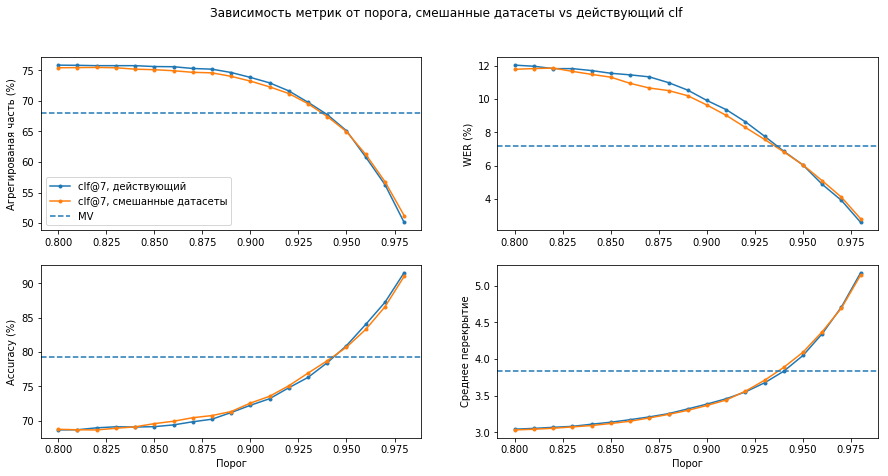

In [119]:
plt.figure(figsize=(15,7))
plt.suptitle('Зависимость метрик от порога, смешанные датасеты vs действующий clf')
plt.subplot(221)
plt.plot(scores_clf_loaded[:, 0], 
         scores_clf_loaded[:, 1] * 100, 
         ".-", 
         label="clf@7, действующий")
plt.plot(scores_clf_test_assistant[:, 0], 
         scores_clf_test_assistant[:, 1] * 100, 
         ".-", 
         label="clf@7, смешанные датасеты")
plt.axhline(y=prod_agg_metrics[0] * 100, color=u'#1f77b4', linestyle='--', label="MV")
plt.legend()
plt.ylabel('Агрегированая часть (%)')

plt.subplot(222)
plt.plot(scores_clf_loaded[:, 0], 
         scores_clf_loaded[:, 2] * 100, 
         ".-")
plt.plot(scores_clf_test_assistant[:, 0], 
         scores_clf_test_assistant[:, 2] * 100, 
         ".-")
plt.axhline(y=prod_agg_metrics[1] * 100, color=u'#1f77b4', linestyle='--')
plt.ylabel('WER (%)')


plt.subplot(223)
plt.plot(scores_clf_loaded[:, 0], 
         scores_clf_loaded[:, 3] * 100, 
         ".-")
plt.plot(scores_clf_test_assistant[:, 0], 
         scores_clf_test_assistant[:, 3] * 100, 
         ".-")
plt.axhline(y=prod_agg_metrics[2] * 100, color=u'#1f77b4', linestyle='--')
plt.ylabel('Accuracy (%)')

plt.xlabel('Порог')

plt.subplot(224)
plt.plot(scores_clf_loaded[:, 0], 
         scores_clf_loaded[:, 4], 
         ".-")
plt.plot(scores_clf_test_assistant[:, 0], 
         scores_clf_test_assistant[:, 4], 
         ".-")
plt.axhline(y=prod_agg_metrics[3], color=u'#1f77b4', linestyle='--')
plt.ylabel('Среднее перекрытие')

plt.xlabel('Порог')

plt.savefig("metrics_mixed_vs_assistant.png")
plt.show()

In [45]:
key = 'https://speechbase-yt.voicetech.yandex.net/getaudio/1014070/1928ae3a-6351-48cf-bed9-dcb5fa12df6e_f78684d2-2275-4e8b-8839-da3590f59cee_1.opus'
len(test_features_q[key][1][0][''][0])

265

In [51]:
clf_q.learning_rate_

0.007102999836

In [52]:
clf = CatBoostClassifier(iterations=500, thread_count=14, random_seed=42)
params = {'iterations': [13000, 17000, 19000, 21000], 'depth': [5, 7, 9, 12]}
gs = GridSearchCV(clf, params, 'roc_auc', cv=5, refit=True, n_jobs=2)

In [ ]:
gs.fit(X_train_q, Y_train_q)

In [ ]:
with open("log_assistant.txt", "a") as log:
    log.write("mixed datasets gs model is fitted\n")

In [56]:
gs.best_params_

{'depth': 5, 'iterations': 13000}

In [57]:
scores_clf_test_assistant_new_hp = []

for treshhold in np.linspace(0.8, 0.98, 19):
    print(treshhold)
    metrics = evaluate_metrics_clf_(valid_assistant_rows, 
                                    test_features_q, 
                                    'raw_assesments', 
                                    gs, 
                                    treshhold,
                                    min_cost=3,
                                    max_cost=7)
    scores_clf_test_assistant_new_hp.append((treshhold, *metrics))
scores_clf_test_assistant_new_hp = np.array(scores_clf_test_assistant_new_hp)

0.8
Aggregated: 75.6741%
WER: 11.9358%
Accuracy: 68.4989%
Mean overlap: 3.043
0.81
Aggregated: 75.6741%
WER: 11.8494%
Accuracy: 68.6884%
Mean overlap: 3.055
0.8200000000000001
Aggregated: 75.7315%
WER: 11.9089%
Accuracy: 68.6364%
Mean overlap: 3.067
0.8300000000000001
Aggregated: 75.6741%
WER: 11.7797%
Accuracy: 68.7263%
Mean overlap: 3.084
0.8400000000000001
Aggregated: 75.5307%
WER: 11.5463%
Accuracy: 68.9328%
Mean overlap: 3.108
0.85
Aggregated: 75.3873%
WER: 11.3822%
Accuracy: 69.1781%
Mean overlap: 3.138
0.86
Aggregated: 75.3873%
WER: 11.2023%
Accuracy: 69.4444%
Mean overlap: 3.185
0.87
Aggregated: 75.1004%
WER: 10.8250%
Accuracy: 70.2063%
Mean overlap: 3.237
0.88
Aggregated: 74.6701%
WER: 10.5481%
Accuracy: 70.8413%
Mean overlap: 3.284
0.89
Aggregated: 73.9816%
WER: 10.1086%
Accuracy: 71.6169%
Mean overlap: 3.346
0.9
Aggregated: 73.2071%
WER: 9.5249%
Accuracy: 72.7273%
Mean overlap: 3.422
0.91
Aggregated: 72.1457%
WER: 8.7655%
Accuracy: 74.2744%
Mean overlap: 3.526
0.92
Aggregate

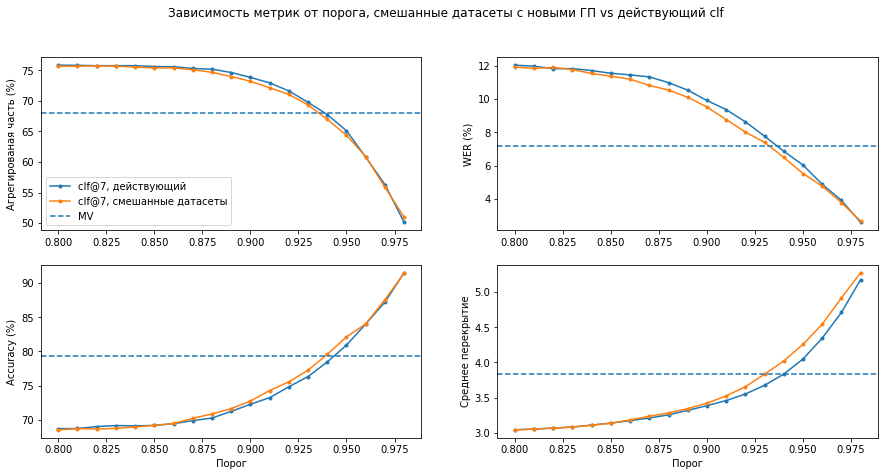

In [120]:
plt.figure(figsize=(15,7))
plt.suptitle('Зависимость метрик от порога, смешанные датасеты с новыми ГП vs действующий clf')
plt.subplot(221)
plt.plot(scores_clf_loaded[:, 0], 
         scores_clf_loaded[:, 1] * 100, 
         ".-", 
         label="clf@7, действующий")
plt.plot(scores_clf_test_assistant_new_hp[:, 0], 
         scores_clf_test_assistant_new_hp[:, 1] * 100, 
         ".-", 
         label="clf@7, смешанные датасеты")
plt.axhline(y=prod_agg_metrics[0] * 100, color=u'#1f77b4', linestyle='--', label="MV")
plt.legend()
plt.ylabel('Агрегированая часть (%)')

plt.subplot(222)
plt.plot(scores_clf_loaded[:, 0], 
         scores_clf_loaded[:, 2] * 100, 
         ".-")
plt.plot(scores_clf_test_assistant_new_hp[:, 0], 
         scores_clf_test_assistant_new_hp[:, 2] * 100, 
         ".-")
plt.axhline(y=prod_agg_metrics[1] * 100, color=u'#1f77b4', linestyle='--')
plt.ylabel('WER (%)')


plt.subplot(223)
plt.plot(scores_clf_loaded[:, 0], 
         scores_clf_loaded[:, 3] * 100, 
         ".-")
plt.plot(scores_clf_test_assistant_new_hp[:, 0], 
         scores_clf_test_assistant_new_hp[:, 3] * 100, 
         ".-")
plt.axhline(y=prod_agg_metrics[2] * 100, color=u'#1f77b4', linestyle='--')
plt.ylabel('Accuracy (%)')

plt.xlabel('Порог')

plt.subplot(224)
plt.plot(scores_clf_loaded[:, 0], 
         scores_clf_loaded[:, 4], 
         ".-")
plt.plot(scores_clf_test_assistant_new_hp[:, 0], 
         scores_clf_test_assistant_new_hp[:, 4], 
         ".-")
plt.axhline(y=prod_agg_metrics[3], color=u'#1f77b4', linestyle='--')
plt.ylabel('Среднее перекрытие')

plt.xlabel('Порог')

plt.savefig("metrics_mixed_vs_assistant_new_hp.png")
plt.show()

In [88]:
scores_clf_test_assistant_detailed = []

for treshhold in np.linspace(0.93, 0.97, 20):
    print(treshhold)
    metrics = evaluate_metrics_clf_(valid_assistant_rows, 
                                    test_features_q, 
                                    'raw_assesments', 
                                    gs, 
                                    treshhold,
                                    min_cost=3,
                                    max_cost=7)
    scores_clf_test_assistant_detailed.append((treshhold, *metrics))
scores_clf_test_assistant_detailed = np.array(scores_clf_test_assistant_detailed)

0.93
Aggregated: 69.3345%
WER: 7.3921%
Accuracy: 77.2445%
Mean overlap: 3.835
Words counted: 12351
0.9321052631578948
Aggregated: 68.9042%
WER: 7.2215%
Accuracy: 77.7685%
Mean overlap: 3.86
Words counted: 12255
0.9342105263157895
Aggregated: 68.4165%
WER: 7.0301%
Accuracy: 78.3648%
Mean overlap: 3.91
Words counted: 12162
0.9363157894736842
Aggregated: 68.0436%
WER: 6.9065%
Accuracy: 78.7099%
Mean overlap: 3.944
Words counted: 12090
0.9384210526315789
Aggregated: 67.5273%
WER: 6.6567%
Accuracy: 79.1419%
Mean overlap: 3.979
Words counted: 12003
0.9405263157894738
Aggregated: 66.8101%
WER: 6.4467%
Accuracy: 79.6479%
Mean overlap: 4.044
Words counted: 11851
0.9426315789473685
Aggregated: 66.4945%
WER: 6.3123%
Accuracy: 80.0259%
Mean overlap: 4.084
Words counted: 11739
0.9447368421052632
Aggregated: 66.0069%
WER: 6.1899%
Accuracy: 80.3129%
Mean overlap: 4.124
Words counted: 11648
0.9468421052631579
Aggregated: 65.3471%
WER: 5.9977%
Accuracy: 80.8604%
Mean overlap: 4.175
Words counted: 11521

In [89]:
with open('base_line_assistant_2019_10_08.pickle', 'rb') as f:
    baseline_loaded = pickle.load(f)
baseline_loaded

array([9.80000000e-01, 6.44004590e-01, 6.08703160e-02, 8.06236080e-01,
       4.05708548e+00, 1.15820000e+04])

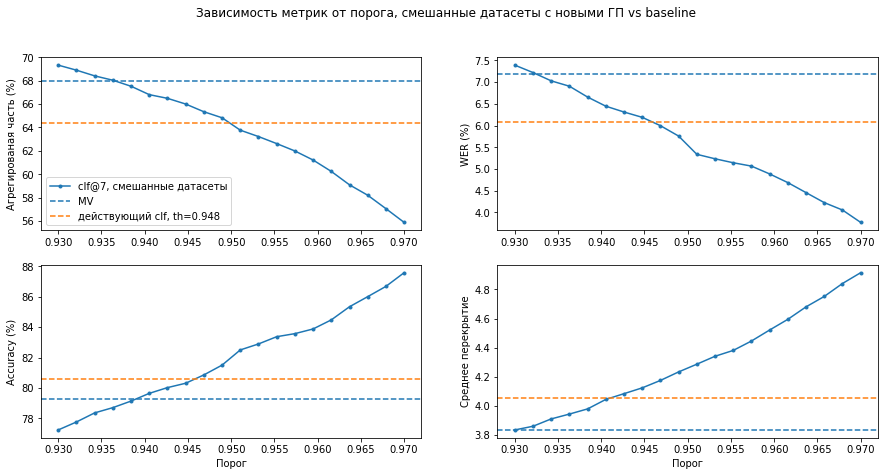

In [121]:
plt.figure(figsize=(15,7))
plt.suptitle('Зависимость метрик от порога, смешанные датасеты с новыми ГП vs baseline')
plt.subplot(221)
plt.plot(scores_clf_test_assistant_detailed[:, 0], 
         scores_clf_test_assistant_detailed[:, 1] * 100, 
         ".-", 
         label="clf@7, смешанные датасеты")
plt.axhline(y=prod_agg_metrics[0] * 100, color=u'#1f77b4', linestyle='--', label="MV")
plt.axhline(y=baseline_loaded[1] * 100, color=u'#ff7f0e', linestyle='--', label="действующий clf, th=0.948")
plt.legend()
plt.ylabel('Агрегированая часть (%)')

plt.subplot(222)
plt.plot(scores_clf_test_assistant_detailed[:, 0], 
         scores_clf_test_assistant_detailed[:, 2] * 100, 
         ".-")
plt.axhline(y=prod_agg_metrics[1] * 100, color=u'#1f77b4', linestyle='--')
plt.axhline(y=baseline_loaded[2] * 100, color=u'#ff7f0e', linestyle='--')
plt.ylabel('WER (%)')


plt.subplot(223)
plt.plot(scores_clf_test_assistant_detailed[:, 0], 
         scores_clf_test_assistant_detailed[:, 3] * 100, 
         ".-")
plt.axhline(y=prod_agg_metrics[2] * 100, color=u'#1f77b4', linestyle='--')
plt.axhline(y=baseline_loaded[3] * 100, color=u'#ff7f0e', linestyle='--')
plt.ylabel('Accuracy (%)')

plt.xlabel('Порог')

plt.subplot(224)
plt.plot(scores_clf_test_assistant_detailed[:, 0], 
         scores_clf_test_assistant_detailed[:, 4], 
         ".-")
plt.axhline(y=prod_agg_metrics[3], color=u'#1f77b4', linestyle='--')
plt.axhline(y=baseline_loaded[4], color=u'#ff7f0e', linestyle='--')
plt.ylabel('Среднее перекрытие')

plt.xlabel('Порог')

plt.savefig("metrics_mixed_detailed_vs_baseline.png")
plt.show()

In [69]:
scores_clf_test_assistant_detailed[7]

array([0.94842105, 0.64859438, 0.0583508 , 0.81335692, 4.21858864])

In [77]:
baseline_loaded

array([0.948     , 0.64400459, 0.06087032, 0.80623608, 4.05708548])

In [78]:
from scipy.stats import norm

In [79]:
def err(value, n, conf=0.9):
    z = norm.ppf(conf)
    return z * np.sqrt(value * (1 - value) / n)

In [80]:
test_words_count = [
    len(row['text'].split()) for row in valid_assistant_rows
]
test_words_count = sum(test_words_count)
test_words_count

13681

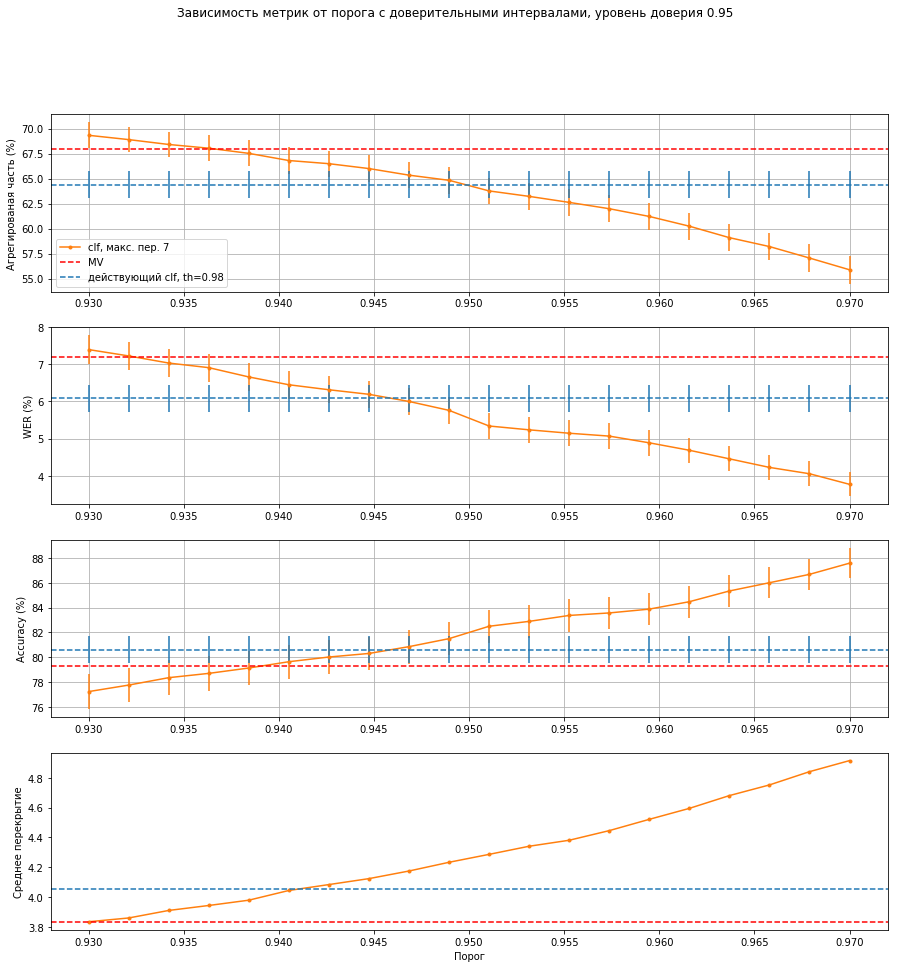

In [122]:
conf = 0.95

plt.figure(figsize=(15,15))
plt.suptitle('Зависимость метрик от порога с доверительными интервалами, уровень доверия {}'.format(conf))
plt.subplot(411)
plt.plot(scores_clf_test_assistant_detailed[:, 0], 
         scores_clf_test_assistant_detailed[:, 1] * 100, 
         ".-", 
         label="clf, макс. пер. 7",
         color=u'#ff7f0e')
plt.errorbar(scores_clf_test_assistant_detailed[:, 0],
            scores_clf_test_assistant_detailed[:, 1] * 100,
            [err(val, len(valid_assistant_rows), conf=conf) * 100 for val in
            scores_clf_test_assistant_detailed[:, 1]],
            color=u'#ff7f0e',
            linestyle="None")
plt.axhline(y=prod_agg_metrics[0] * 100, color='red', linestyle='--', label="MV")
# plt.errorbar(scores_clf_test_assistant_detailed[:, 0],
#             [prod_agg_metrics[0] * 100] * len(scores_clf_test_assistant_detailed[:, 0]),
#             [err(val, len(valid_assistant_rows), conf=conf) * 100 for val in 
#             [prod_agg_metrics[0]] * len(scores_clf_test_assistant_detailed[:, 0])],
#             color='red',
#             linestyle="None")
plt.axhline(y=baseline_loaded[1] * 100, color=u'#1f77b4', linestyle='--', 
            label="действующий clf, th={}".format(baseline_loaded[0]))
plt.errorbar(scores_clf_test_assistant_detailed[:, 0],
            [baseline_loaded[1] * 100] * len(scores_clf_test_assistant_detailed[:, 0]),
            [err(val, len(valid_assistant_rows), conf=conf) * 100 for val in 
            [baseline_loaded[1]] * len(scores_clf_test_assistant_detailed[:, 0])],
            color=u'#1f77b4',
            linestyle="None")
plt.ylabel('Агрегированая часть (%)')
plt.grid(True)
plt.legend()

plt.subplot(412)
plt.plot(scores_clf_test_assistant_detailed[:, 0], 
         scores_clf_test_assistant_detailed[:, 2] * 100, 
         ".-",
         color=u'#ff7f0e')
plt.errorbar(scores_clf_test_assistant_detailed[:, 0],
            scores_clf_test_assistant_detailed[:, 2] * 100,
            [err(val[2], val[5], conf=conf) * 100 for val in
            scores_clf_test_assistant_detailed[:]],
            color=u'#ff7f0e',
            linestyle="None")
plt.axhline(y=prod_agg_metrics[1] * 100, color='red', linestyle='--')
# plt.errorbar(scores_clf_test_assistant_detailed[:, 0],
#             [prod_agg_metrics[1] * 100] * len(scores_clf_test_assistant_detailed[:, 0]),
#             [err(val, prod_agg_metrics[4], conf=conf) * 100 for val in 
#             [prod_agg_metrics[1]] * len(scores_clf_test_assistant_detailed[:, 0])],
#             color='red',
#             linestyle="None")
plt.axhline(y=baseline_loaded[2] * 100, color=u'#1f77b4', linestyle='--')
plt.errorbar(scores_clf_test_assistant_detailed[:, 0],
            [baseline_loaded[2] * 100] * len(scores_clf_test_assistant_detailed[:, 0]),
            [err(val, baseline_loaded[5], conf=conf) * 100 for val in 
            [baseline_loaded[2]] * len(scores_clf_test_assistant_detailed[:, 0])],
            color=u'#1f77b4',
            linestyle="None")
plt.grid(True)
plt.ylabel('WER (%)')

plt.subplot(413)
plt.plot(scores_clf_test_assistant_detailed[:, 0], 
         scores_clf_test_assistant_detailed[:, 3] * 100, 
         ".-",
         color=u'#ff7f0e')
plt.errorbar(scores_clf_test_assistant_detailed[:, 0],
            scores_clf_test_assistant_detailed[:, 3] * 100,
            [err(metrics[3], metrics[1] * len(valid_assistant_rows), conf=conf) * 100 for metrics in
            scores_clf_test_assistant_detailed[:]],
            color=u'#ff7f0e',
            linestyle="None")
plt.axhline(y=prod_agg_metrics[2] * 100, color='red', linestyle='--')
# plt.errorbar(scores_clf_test_assistant_detailed[:, 0],
#             [prod_agg_metrics[2] * 100] * len(scores_clf_test_assistant_detailed[:, 0]),
#             yerr=[err(val, prod_agg_metrics[0] * len(valid_assistant_rows), conf=conf) * 100 for val in 
#             [prod_agg_metrics[2]] * len(scores_clf_test_assistant_detailed[:, 0])],
#             color='red',
#             linestyle="None")
plt.axhline(y=baseline_loaded[3] * 100, color=u'#1f77b4', linestyle='--')
plt.errorbar(scores_clf_test_assistant_detailed[:, 0],
            [baseline_loaded[3] * 100] * len(scores_clf_test_assistant_detailed[:, 0]),
            yerr=[err(val, baseline_loaded[0] * len(valid_assistant_rows), conf=conf) * 100 for val in 
            [baseline_loaded[3]] * len(scores_clf_test_assistant_detailed[:, 0])],
            color=u'#1f77b4',
            linestyle="None")
plt.grid(True)
plt.ylabel('Accuracy (%)')

plt.subplot(414)
plt.plot(scores_clf_test_assistant_detailed[:, 0], 
         scores_clf_test_assistant_detailed[:, 4], 
         ".-",
         color=u'#ff7f0e')
plt.axhline(y=prod_agg_metrics[3], color='red', linestyle='--')
plt.axhline(y=baseline_loaded[4], color=u'#1f77b4', linestyle='--')
plt.ylabel('Среднее перекрытие')

plt.xlabel('Порог')

plt.savefig("metrics_conf_int_mixed_vs_baseline.png")
plt.show()

In [93]:
baseline_loaded

array([9.80000000e-01, 6.44004590e-01, 6.08703160e-02, 8.06236080e-01,
       4.05708548e+00, 1.15820000e+04])

In [115]:
prod_agg_metrics = evaluate_metrics(valid_assistant_rows, 
                                    'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                    aggregate_prod) 

Aggregated: 67.9862%
WER: 7.2800%
Accuracy: 79.0295%
Mean overlap: 3.833


In [95]:
prod_agg_metrics

(0.6798623063683304,
 0.07280043899762209,
 0.7902953586497891,
 3.8330464716006887,
 10934)

In [108]:
scores_clf_test_assistant_detailed[9][4] / baseline_loaded[4]

1.0434844092483915

In [109]:
scores_clf_test_assistant_detailed[9][4], baseline_loaded[4]

(4.23350545037292, 4.057085484796328)

In [128]:
# Prod baseline
prod_agg_metrics = utils_metrics.evaluate_metrics_for_algorithm(valid_assistant_rows, 
                                    'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                    aggregate_prod)

Recall: 88.0484%
WER: 13.3954%
Mean overlap: 3.833


In [131]:
preaggregated = preaggregate_with_clf(test_features_q, gs)

In [133]:
from functools import partial

In [134]:
scores_clf_test_new_wer = []

for treshhold in np.linspace(0.8, 0.98, 19):
    print(treshhold)
    metrics = evaluate_metrics_clf_(valid_assistant_rows, 
                                    test_features_q, 
                                    'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                    gs, 
                                    treshhold,
                                    min_cost=3,
                                    max_cost=7,
                                    agg_method=partial(aggregate_rover_with_clf_,
                                                       preaggregated=preaggregated))
    scores_clf_test_new_wer.append((treshhold, *metrics))
scores_clf_test_new_wer = np.array(scores_clf_test_new_wer)

0.8
Recall: 95.1976%
WER: 13.9833%
Mean overlap: 3.043
0.81
Recall: 95.2012%
WER: 13.9247%
Mean overlap: 3.055
0.8200000000000001
Recall: 95.2614%
WER: 13.8742%
Mean overlap: 3.067
0.8300000000000001
Recall: 95.2474%
WER: 13.6707%
Mean overlap: 3.084
0.8400000000000001
Recall: 95.1556%
WER: 13.3936%
Mean overlap: 3.108
0.85
Recall: 95.1448%
WER: 13.2279%
Mean overlap: 3.138
0.86
Recall: 95.2597%
WER: 12.3472%
Mean overlap: 3.185
0.87
Recall: 94.9977%
WER: 11.9269%
Mean overlap: 3.237
0.88
Recall: 94.5825%
WER: 11.6729%
Mean overlap: 3.284
0.89
Recall: 93.9900%
WER: 11.2810%
Mean overlap: 3.346
0.9
Recall: 93.2225%
WER: 10.6478%
Mean overlap: 3.422
0.91
Recall: 92.3596%
WER: 9.7119%
Mean overlap: 3.526
0.92
Recall: 91.3085%
WER: 8.7968%
Mean overlap: 3.655
0.9299999999999999
Recall: 89.2663%
WER: 8.1211%
Mean overlap: 3.835
0.94
Recall: 86.7284%
WER: 7.1554%
Mean overlap: 4.021
0.95
Recall: 83.5458%
WER: 6.1398%
Mean overlap: 4.257
0.96
Recall: 79.1355%
WER: 5.3338%
Mean overlap: 4.543


In [139]:
with open('base_line_new_metrics_solo_assistant.pickle', 'rb') as f:
    baseline_loaded_new_metrics = pickle.load(f)
baseline_loaded_new_metrics

array([0.98      , 0.86047811, 0.06822048, 4.00143431])

In [141]:
import seaborn as sns
sns.set(style="whitegrid")

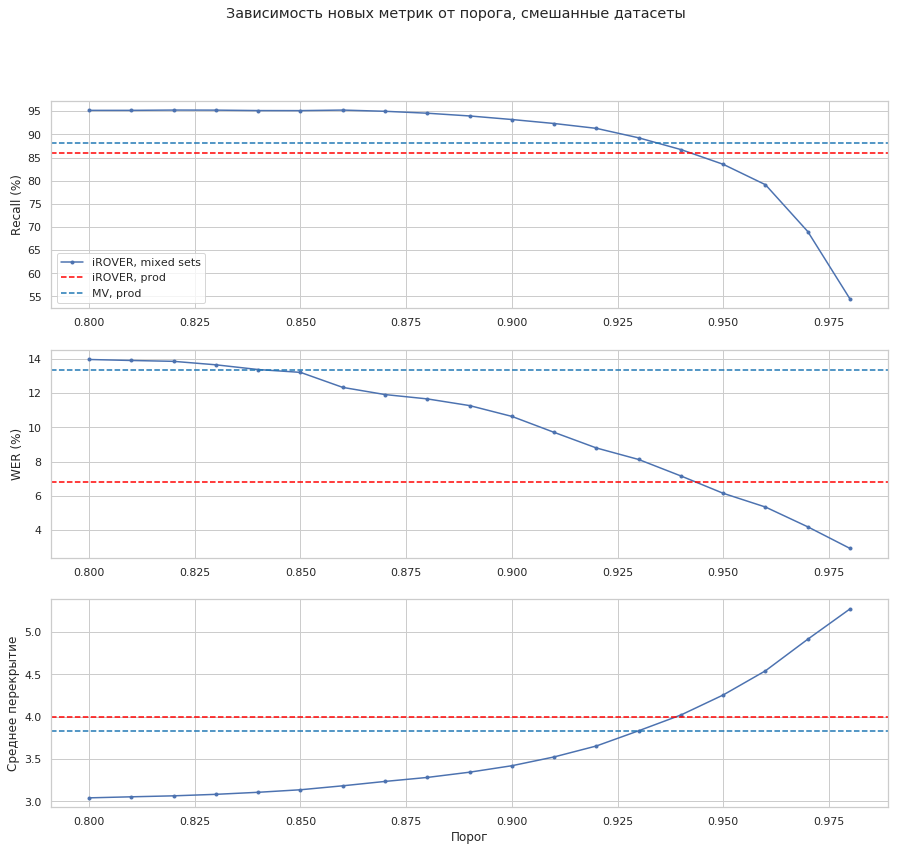

In [142]:
plt.figure(figsize=(15,13))
plt.suptitle('Зависимость новых метрик от порога, смешанные датасеты')
plt.subplot(311)
plt.plot(scores_clf_test_new_wer[:, 0], 
         scores_clf_test_new_wer[:, 1] * 100, 
         ".-", 
         label="iROVER, mixed sets")
plt.axhline(y=baseline_loaded_new_metrics[1] * 100, color='red', linestyle='--', label="iROVER, prod")
plt.axhline(y=prod_agg_metrics[0] * 100, color=u'#1f77b4', linestyle='--', label="MV, prod")
plt.legend()
plt.ylabel('Recall (%)')

plt.subplot(312)
plt.plot(scores_clf_test_new_wer[:, 0], 
         scores_clf_test_new_wer[:, 2] * 100, 
         ".-")
plt.axhline(y=baseline_loaded_new_metrics[2] * 100, color='red', linestyle='--')
plt.axhline(y=prod_agg_metrics[1] * 100, color=u'#1f77b4', linestyle='--')
plt.ylabel('WER (%)')

plt.subplot(313)
plt.plot(scores_clf_test_new_wer[:, 0], 
         scores_clf_test_new_wer[:, 3], 
         ".-")
plt.axhline(y=baseline_loaded_new_metrics[3], color='red', linestyle='--')
plt.axhline(y=prod_agg_metrics[2], color=u'#1f77b4', linestyle='--')
plt.ylabel('Среднее перекрытие')

plt.xlabel('Порог')

plt.savefig("mixed_new_metrics.png")
plt.show()